In [1]:
import pandas as pd
import folium
from folium import plugins
from timeit import default_timer as timer
import math
import numpy as np
import copy
import matplotlib.pyplot as plt
from datetime import datetime
import json
import seaborn as sns

In [2]:
path_to_data = r".\data\trips.pkl"
period_duration = 2 # length of a period in hours
region_size = 2.5 # in km

# to save results
path_to_demand = r".\data\demand.pkl"
path_to_actual_demand = r".\data\actual_demand.pkl"
path_to_centers = r".\data\centers.pkl"

In [3]:
start = timer()
trips_raw = pd.read_pickle(path_to_data)
end = timer()
print(f"Succesfully loaded pickle file in dataframe in {(end - start):.2f} seconds")

Succesfully loaded pickle file in dataframe in 1.25 seconds


In [4]:
trips = trips_raw.copy()

In [5]:
# remove entries where the duration is longer than our period duration
trips = trips[trips['duration'] < period_duration * 60 * 60]

In [6]:
trips = trips.filter(['id', 'datetime_start', 'datetime_end', 'longitude_start', 'latitude_start', 'latitude_end', 'longitude_end', 'start', 'end'])

### Split service region in grid

First we determine a square that contains all trips start and end locations.

In [7]:
lons = pd.concat([trips['longitude_start'], trips['longitude_end']])
lats = pd.concat([trips['latitude_start'], trips['latitude_end']])

In [8]:
lat_min = lats.min()
lat_max = lats.max()
lon_min = lons.min()
lon_max = lons.max()

points = [(lat_max, lon_min), (lat_min, lon_min), (lat_min, lon_max), (lat_max, lon_max), (lat_max, lon_min)]

In [9]:
fmap = folium.Map(location=(50.9253, 6.9495), zoom_start=11, control_scale=True, max_zoom=20)
folium.PolyLine(points).add_to(fmap)
display(fmap)

We now will split this square into multiple squares with length equal to `region_size`.  
To accomplish this we define a function `add_meter_offset`. This function takes a coordinate as parameter and adds an specified offset. The result is a approximation.

In [10]:
R = 6373
pi = math.pi

def add_meter_offset(coord, xd = 0, yd = 0):
    return [
        coord[0]  + (yd / R) * (180 / pi),
        coord[1] + (xd / R) * (180 / pi) / math.cos(coord[0] * pi/180)
    ]

In [11]:
grid = []

left_vertical_line = []

lat = lat_min
while lat < lat_max:
    left_vertical_line.append([lat, lon_min])
    lat = add_meter_offset([lat, lon_min], yd = region_size)[0]
left_vertical_line.append([lat, lon_min])

In [12]:
lon = lon_min
while lon < lon_max:
    vertical_line = list(map(lambda coord: [coord[0], lon],left_vertical_line))
    grid.append(vertical_line)
    lon = add_meter_offset([vertical_line[0][0], lon], xd = region_size)[1]
grid.append(list(map(lambda coord: [coord[0], lon],left_vertical_line)))

The map below shows the corners of each region. Note that some regions fall outside of the original square. This may occur because the specified `region_size` does not perfectly fill the original square.

In [13]:
for j, line in enumerate(grid):
    for i,coord in enumerate(line):        
        folium.Marker(coord, popup=(str(coord))).add_to(fmap)
folium.Marker(grid[-1][-1]).add_to(fmap)
display(fmap)

### Calculate coordinates of region centers

Later we are going to calculate distances between regions. Therefore  we will now define and save the region centers.  
To define the centers we add an vertical (latitude) and horizontal (longitude) offset of `region_size / 2` to each corner, except the most northern and most eastern corners.

In [14]:
centers = list(map(lambda vertical_line: vertical_line[0:-1], copy.deepcopy(grid)))
centers = centers[0:-1]

In [15]:
for vertical_line in centers:
    for coord in vertical_line:
        new_coord = add_meter_offset(coord, xd=region_size/2, yd=region_size/2)
        coord[0] = new_coord[0]
        coord[1] = new_coord[1]

In [16]:
centers = np.moveaxis(np.array(centers),0,1)

In [17]:
centers = pd.DataFrame(centers.reshape(-1,2), columns=['lat', 'lon']).reset_index().rename(columns={'index': 'center'})

In [18]:
x_length = len(grid) - 1
y_length = len(grid[0]) -1 
n_regions = x_length * y_length
print(f"The total number of regions is: {n_regions}")

The total number of regions is: 81


### Determine start and end region of each trip

In [19]:
def assign_region(coord):
    region = 0
    for i, vertical_line in enumerate(grid):
        if coord[1] < vertical_line[0][1]:
            region = i
            break
    for i, coord_grid in enumerate(grid[0]):
        if coord[0] < coord_grid[0]:
            region += ((i-1) * x_length)
            break
    return region - 1

In [20]:
start = timer()

trips['region_start'] = trips['start'].apply(assign_region)
trips['region_end'] = trips['end'].apply(assign_region)

end = timer()
print(f"Succesfully classified trips into {n_regions} regions in {(end - start):.2f} seconds")

Succesfully classified trips into 81 regions in 5.17 seconds


To reduce dimensionality we will now drop all regions that do not contain any trips.

In [21]:
regions = pd.concat([trips['region_start'], trips['region_end']]).unique()

In [22]:
print(f"Number of regions without any trips: {n_regions - len(regions)}")

Number of regions without any trips: 19


We also rename the regions by counting them. This allows us to drop unusued regions from further consideration, which reduces dimensionality.

In [23]:
regions_dict = {region: i for i,region in enumerate(regions)}

In [24]:
# reset regions names to 0,1,...
centers_renamed = centers.copy()

trips['region_start'] = trips['region_start'].map(regions_dict)
trips['region_end'] = trips['region_end'].map(regions_dict)
centers_renamed['center'] = centers['center'].map(regions_dict)

In [25]:
regions = pd.concat([trips['region_start'], trips['region_end']]).unique()

In [26]:
centers_renamed = centers_renamed.dropna()
centers_renamed['center'] = centers_renamed['center'].apply(int)

In [27]:
centers_renamed = centers_renamed.sort_values(['center']).set_index(['center'])

We save the regions centers, because we will later use them to calculate distances between regions.

In [29]:
centers_renamed.to_pickle(path_to_centers)

In [30]:
print(f"Number of used regions: {len(regions)}")
n_regions = len(regions)

Number of used regions: 62


### Group trips in periods

In [31]:
trips_floor = trips.copy()

In [32]:
trips_floor['datetime_start'] = trips['datetime_start'].dt.floor('%dH' % period_duration)

In [33]:
trips_sm = trips_floor.filter(['region_start', 'region_end', 'datetime_start'])

Each entry in the dataframe `trips_sm` corresponds to one trip. We insert a new column `demand` with the value `1` for every entry.  
When we group the dataframe by `datetime_start`, `region_start` and `region_end` we simply sum up the `demand` column and get the overall demand from one region to another in a speficic period.

In [34]:
trips_sm['demand'] = 1

When grouping the trips, we do not get every possible index combination there is. However to properly predict future demand, we need the same dimensions that we now use to train the predicte model. Therefore we reindex the grouped trips with the crossproduct of datetime_start, region_start, region_end.

In [35]:
start = timer()

trips_agg_full = trips_sm.groupby(['datetime_start','region_start', 'region_end']).size().to_frame('demand')\
                         .reindex(pd.MultiIndex.from_product([trips_sm['datetime_start'].unique(), 
                                                              trips_sm['region_start'].unique(), 
                                                              trips_sm['region_end'].unique()], 
                                                             names=['datetime_start', 'region_start', 'region_end']))

end = timer()
print(f"Succesfully grouped trips in {(end - start):.2f} seconds")

Succesfully grouped trips in 25.89 seconds


In [36]:
trips_agg_full = trips_agg_full.fillna(0)

In [37]:
trips_agg = trips_agg_full.reset_index()

In [38]:
actual_demand = trips_agg[['datetime_start', 'region_start', 'region_end', 'demand']].rename(columns={'datetime_start': 'datetime'})

In [39]:
start = timer()

actual_demand.to_pickle(path_to_actual_demand)

end = timer()
print(f"Succesfully classified trips into {n_regions} regions in {(end - start):.2f} seconds")

Succesfully classified trips into 62 regions in 0.39 seconds


### Create features
We will use the `datetime` column to create new columns `weekday`, `year_day` and `hour` to use them in the regression.

In [40]:
def extract_features_from_datetime(input_df, datetime_col = 'datetime'):
    dataframe = input_df.copy()
    dataframe['weekday'] = dataframe[datetime_col].dt.weekday
    dataframe['year_day'] = dataframe[datetime_col].dt.dayofyear
    dataframe['hour'] = dataframe[datetime_col].dt.hour
    dataframe['is_weekend'] = dataframe['weekday'] > 4
    return dataframe

In [41]:
extra_features = ['weekday', 'year_day', 'hour', 'is_weekend']

In [42]:
trips_agg = trips_agg.rename(columns={'datetime_start': 'datetime'})

In [43]:
# make features
start = timer()
trips_agg = extract_features_from_datetime(trips_agg)
end = timer()
print(f"Succesfully extracted datetime features in {(end - start):.2f} seconds")

Succesfully extracted datetime features in 1.02 seconds


Some regions are only used as endpoint or only as startpoint. Therefore if we would just create dummies from the `region_start` and `region_end` columns there would be dummies missing (the one's that are never uses). However this makes it difficult for us to generate the actual prediction. So we just insert one row for every possible entry in `region_start` and `region_end`.

In [44]:
dummy_filler_df = pd.DataFrame(
    [[datetime.now(), region, region, 0 , 0, 0, 0, 0] for region in range(n_regions)], 
    columns=['datetime', 'region_start', 'region_end', 'demand'] + extra_features)

In [45]:
trips_agg = pd.concat([trips_agg, dummy_filler_df], ignore_index=True)

In [46]:
trips_agg_dummies = trips_agg.join(pd.get_dummies(trips_agg['region_start'], prefix="rs"))
trips_agg_dummies = trips_agg_dummies.join(pd.get_dummies(trips_agg['region_end'], prefix="re"))

Delete artificially inserted rows.

In [47]:
trips_agg_dummies = trips_agg_dummies.drop(trips_agg_dummies.tail(n_regions).index)

### Create Model

To get a sophisticated predictive model, we will first try out various models with default hyperparameters.  
We will then select the best performing model and run a randomized hyperparameter search on it.
To remain computationally tractable we have to perform the randomized search, as well as the model search on a subset of the available data.  

When we have decided for a model and the hyperparameters, we will then refit that model on the whole training data.

In [50]:
trips_agg_sm = trips_agg_dummies.sample(frac=0.2, random_state=42)

In [52]:
X = trips_agg_sm.drop(['demand' ,'datetime', 'region_start', 'region_end'], axis=1)
y = trips_agg_sm['demand']

In [53]:
X_full = trips_agg_dummies.drop(['demand' ,'datetime', 'region_start', 'region_end'], axis=1)
y_full = trips_agg_dummies['demand']

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import multiprocessing

In [55]:
def split_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4711)
    for name, data in {'train': X_train, 'test': X_test}.items():
        print(f"""{name}
        {len(data)} entries
        ~{(len(data)/len(X)*100):.2f}% of total data""")      
    return X_train, X_test, y_train, y_test 

In [56]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    train_predict = model.predict(X_train)
    train_mse = mean_squared_error(y_train, train_predict)
    train_mae = mean_absolute_error(y_train, train_predict)
    train_r2 = r2_score(y_train, train_predict)
    
    test_predict = model.predict(X_test)
    test_mse = mean_squared_error(y_test, test_predict)
    test_mae = mean_absolute_error(y_test, test_predict)
    test_r2 = r2_score(y_test, test_predict)

    print(f"""Training
    
    Mean-Squared-Error:             {train_mse:8.4f}
    Mean-Absolute-Error:            {train_mae:8.4f}
    R2-Score:                       {train_r2:4.2f}
    
    
    Testing
    
    Mean-Squared-Error:             {test_mse:8.4f}
    Mean-Absolute-Error:            {test_mae:8.4f}
    R2-Score:                       {test_r2:4.2f}
    """)
    return (test_mse, test_mae)

In [57]:
X_train, X_test, y_train, y_test  = split_data(X,y)

train
        612189 entries
        ~70.00% of total data
test
        262368 entries
        ~30.00% of total data


In [58]:
X_train_full, X_test_full, y_train_full, y_test_full  = split_data(X_full,y_full)

train
        3060949 entries
        ~70.00% of total data
test
        1311836 entries
        ~30.00% of total data


In [59]:
models = [
    ('Linear Regression',
    make_pipeline(
        StandardScaler(),
        LinearRegression(n_jobs=-2),
    )),
    
    ('Random Forest',
    RandomForestRegressor(criterion = "mse", bootstrap=True, n_estimators=7, max_samples=0.3, n_jobs=-2, random_state=42)),
    
    ('Decision Tree',
    DecisionTreeRegressor()),
    
    ('KNN',
    make_pipeline(
        MinMaxScaler((0,1)), # not tractable
        KNeighborsRegressor(n_jobs=-2),
    )),
    
    ('SVR RBF', 
    make_pipeline(
        StandardScaler(),  # not tractable
        SVR(kernel="rbf", cache_size=8000),
    )
    ),
]

In [61]:
from workers import fit_model
import multiprocessing
from multiprocessing import Pool

Some of the models we try could take too long to train. Therefore we want to set a timeout after which we terminate the training process and discard the model.  
To accomplish this we use python multiprocessing module and train each model in a seperate process, that we can terminate after the specified timeout.  
We could also use this technique to train the models in parallel, however some of the models already use multiple processes (random forest), therefore we will not train them in parallel.

In [62]:
start = timer()
fitted_models = {}
if __name__ == "__main__":
    manager = multiprocessing.Manager()
    return_dict = manager.dict()
    timeout = 300
    print(f'timeout set on {timeout} seconds')
    
    for name, model in models:
        start_p = timer()
        print('\n')
        print(f'Fitting model: {name}')

        p = multiprocessing.Process(target=fit_model, args=(model, name, X_train, y_train, return_dict))
        p.start()


        p.join(timeout)
        if p.is_alive():
            print(f'model {name} took longer than {timeout} seconds')
            print('terminating...')
            p.terminate()
            print(f'terminated {name}')
        else:
            print(f'succesfully fitted model {name} in {timer() - start:.2f} seconds')
            
    for name, model in models:
        fitted_models[name] = return_dict.get(name)
print('\n')
print(f'Finished in {timer() - start:.2f} seconds')

timeout set on 300 seconds


Fitting model: Linear Regression
succesfully fitted model Linear Regression in 10.46 seconds


Fitting model: Random Forest
succesfully fitted model Random Forest in 38.00 seconds


Fitting model: Decision Tree
succesfully fitted model Decision Tree in 64.54 seconds


Fitting model: KNN
model KNN took longer than 300 seconds
terminating...
terminated KNN


Fitting model: SVR RBF
model SVR RBF took longer than 300 seconds
terminating...
terminated SVR RBF


Finished in 667.20 seconds


In [64]:
fitted_models_success = {name: model for name, model in fitted_models.items() if model is not None}

After succesfully fitting (some) of the models, we will now evaluate them with the test data.

In [65]:
start = timer()

results = {}
for name, model in fitted_models_success.items():
    print('\n')
    print(f"Evaluating model: {name}")
    mse, mae = evaluate_model(model, X_train, y_train, X_test, y_test)
    results[name] = {'mse': mse, 'mae': mae}
    print(f"Finished evaluating model: {name} in {timer()-start:.2f} seconds.")




Evaluating model: Linear Regression
Training
    
    Mean-Squared-Error:              14.8122
    Mean-Absolute-Error:              0.5806
    R2-Score:                       0.05
    
    
    Testing
    
    Mean-Squared-Error:              16.3770
    Mean-Absolute-Error:              0.5923
    R2-Score:                       0.06
    
Finished evaluating model: Linear Regression in 1.51 seconds.


Evaluating model: Random Forest
Training
    
    Mean-Squared-Error:               1.2419
    Mean-Absolute-Error:              0.1035
    R2-Score:                       0.92
    
    
    Testing
    
    Mean-Squared-Error:               2.3799
    Mean-Absolute-Error:              0.1413
    R2-Score:                       0.86
    
Finished evaluating model: Random Forest in 2.57 seconds.


Evaluating model: Decision Tree
Training
    
    Mean-Squared-Error:               0.0000
    Mean-Absolute-Error:              0.0000
    R2-Score:                       1.00
    
    
   

In [66]:
l = []
for i, result in enumerate(results.items()):
    name, metrics = result
    mse = metrics['mse']
    mae = metrics['mae']
    l.append([mse,'mse',name])
    l.append([mae,'mae',name])
results_df = pd.DataFrame(l, columns=['performance', 'metric', 'model'])

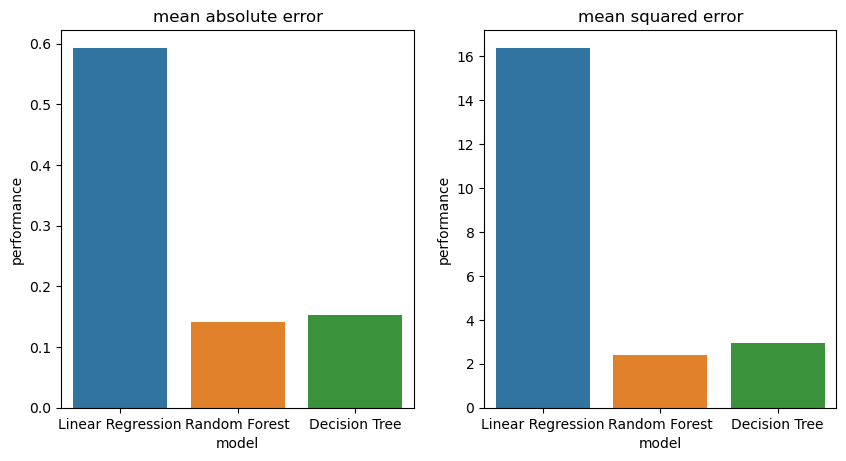

In [67]:
fig,axes = plt.subplots(figsize=(10,5), ncols=2, dpi= 100, facecolor='white') 

sns.barplot(data=results_df[results_df['metric'] == 'mae'], x='model', y='performance', ax=axes[0])
sns.barplot(data=results_df[results_df['metric'] == 'mse'], x='model', y='performance', ax=axes[1])

axes[0].set_title('mean absolute error')
axes[1].set_title('mean squared error')

plt.savefig('./figures/model_comparison.pdf')
plt.show()

The Random Forest Regressor performed best, so we choose this model.  
We go on by tweaking the hyperparameters.

In [68]:
model = RandomForestRegressor(criterion = "mse", bootstrap=True, n_estimators=7, max_samples=0.2, n_jobs=-2)

We use the following hyperparameter grid for the randomized search.

In [69]:
hyperparameters = {
     'max_depth': [5, 10, 20, 30, 50, 100, None],
     'max_features': ['auto', 'sqrt', 'log2'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10],
     'n_estimators': [8,16,24,32]
    }

This gives us a 189 different hyperparameter settings.

In [70]:
from sklearn.model_selection import RandomizedSearchCV

We will now sample 30 random hyperparameter settings from the hyperparameter grid and compare their performance using 3-fold cross validation.

### NOTE
Performing the randomized search took about 15 minutes on my machine (8 virtual cores). And if n_jobs=1, then all cores are fully used, which in my case made my pc unusable during that time. If you want to work on something else while this runs, you can set n_job=-2, to keep one core free.

In [71]:
model_random = RandomizedSearchCV(estimator=model, param_distributions=hyperparameters, n_iter = 30, cv = 3, verbose=2, refit=False, random_state=42, n_jobs=-1)

In [72]:
start = timer()
model_random.fit(X_train, y_train)
end = timer()
print(f"Succesfully fitted model in {(end - start):.2f} seconds")

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min


Succesfully fitted model in 966.47 seconds


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 16.1min finished


We now found the hyperparameters, that we will use for the predictive model.

In [73]:
params = model_random.best_params_
print(params)

{'n_estimators': 24, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 50}


Finally we retrain the model on the whole training data.

In [74]:
X_train, X_test, y_train, y_test  = split_data(X_full,y_full)

train
        3060949 entries
        ~70.00% of total data
test
        1311836 entries
        ~30.00% of total data


In [75]:
final_model = RandomForestRegressor(criterion = "mse", bootstrap=True, max_samples=0.2, n_jobs=-2, verbose=2, **params)

In [76]:
start = timer()
final_model.fit(X_train, y_train)
end = timer()
print(f"Succesfully fitted model in {(end - start):.2f} seconds")

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.


building tree 1 of 24
building tree 2 of 24
building tree 3 of 24
building tree 4 of 24
building tree 5 of 24building tree 6 of 24

building tree 7 of 24
building tree 8 of 24
building tree 9 of 24
building tree 10 of 24
building tree 11 of 24
building tree 12 of 24
building tree 13 of 24
building tree 14 of 24
building tree 15 of 24
building tree 16 of 24
building tree 17 of 24
building tree 18 of 24
building tree 19 of 24
building tree 20 of 24
building tree 21 of 24
building tree 22 of 24
building tree 23 of 24
building tree 24 of 24
Succesfully fitted model in 368.88 seconds


[Parallel(n_jobs=-2)]: Done  24 out of  24 | elapsed:  6.1min remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  24 out of  24 | elapsed:  6.1min finished


In [72]:
start = timer()

evaluate_model(model=final_model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

end = timer()
print(f"Succesfully evaluated model in {(end - start):.2f} seconds")

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  24 out of  24 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=7)]: Done  24 out of  24 | elapsed:    6.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  24 out of  24 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=7)]: Done  24 out of  24 | elapsed:    2.5s finished


Training
    
    Mean-Squared-Error:               1.0437
    Mean-Absolute-Error:              0.1009
    R2-Score:                       0.92
    
    
    Testing
    
    Mean-Squared-Error:               1.6563
    Mean-Absolute-Error:              0.1166
    R2-Score:                       0.91
    
Succesfully evaluated model in 12.78 seconds


### Predict Demand

Now we can predict future demand with our fitted model.  
In order to do that we first need to prepare the input for the predictive model.

In [77]:
last_date = trips_agg['datetime'].max()
last_date

Timestamp('2021-01-22 11:15:41.364038')

In [111]:
dates = pd.date_range(start=last_date, freq='%dH' % period_duration, periods=13)
dates = dates[1:] # drop first row, we only want future dates

In [112]:
ends = [end for end in range(n_regions)] 
starts =  [start for start in range(n_regions)]

In [113]:
X_predict = pd.DataFrame(np.array(np.meshgrid(dates.values, starts,ends)).T.reshape(-1,3))

In [114]:
X_predict = X_predict.rename(columns={0:'datetime', 1:'region_start', 2:'region_end'})

In [115]:
X_predict['datetime'] = pd.to_datetime(X_predict['datetime'])

In [116]:
X_predict = extract_features_from_datetime(X_predict)
X_datetime = X_predict['datetime']
X_predict = X_predict.drop(['datetime'], axis=1)

In [117]:
X_predict = X_predict.join(pd.get_dummies(X_predict['region_start'], prefix="rs"))
X_predict = X_predict.join(pd.get_dummies(X_predict['region_end'], prefix="re"))
X_predict = X_predict.drop(['region_start', 'region_end'], axis=1)

In [119]:
demand_values = pd.DataFrame(final_model.predict(X_predict))

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  24 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=7)]: Done  24 out of  24 | elapsed:    0.0s finished


In [120]:
demand_values = demand_values.rename(columns={0: 'demand'})

In [122]:
demand = pd.merge(demand_values,X_predict, left_index=True, right_index=True)

In [123]:
start_columns = [f"rs_{i}" for i in range(n_regions)]
end_columns = [f"re_{i}" for i in range(n_regions)]

In [124]:
dummies_start = demand[start_columns]
dummies_end = demand[end_columns]

In [125]:
demand['region_start'] = dummies_start.idxmax(axis=1)
demand['region_end'] = dummies_end.idxmax(axis=1)

In [126]:
demand = demand.drop(start_columns + end_columns + ['weekday', 'year_day', 'hour', 'is_weekend'], axis=1)

In [127]:
demand['datetime'] = X_datetime

In [128]:
demand['region_start'] = demand['region_start'].apply(lambda x: int(str(x).replace('rs_', '')))
demand['region_end'] = demand['region_end'].apply(lambda x: int(str(x).replace('re_', '')))

In [129]:
demand.to_pickle(path_to_demand)